In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import os
from pprint import pprint
import spacy

# Gensim
# !pip install gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 
import seaborn as sns
%matplotlib inline

## Loading & Cleaning the data

In [10]:
#this file has been pre-processed so that each individual user review is extracted into a single row and duplicate reviews have been removed.
data=pd.read_csv('Zomato_cleaned_computer_readable.csv')

data.rename( columns={'Unnamed: 0':'rest_key'}, inplace=True )
data.head()

,rest_key,name,address,online_order,book_table,rate,votes,location,approx_cost(for two people),listed_in(city),...,rest_type_Lounge,rest_type_Meat Shop,rest_type_Mess,rest_type_Microbrewery,rest_type_Pop Up,rest_type_Pub,rest_type_Quick Bites,rest_type_Sweet Shop,rest_type_Takeaway,rest_type_nan
0,0,#FeelTheROLL,"Opposite Mantri Commercio, Outer Ring Road, De...",False,False,3.4,7,Bellandur,200.0,"Sarjapur Road,Bellandur",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,#L-81 Cafe,"Sector 6, HSR Layout, HSR",True,False,3.9,48,HSR,400.0,"Koramangala 7th Block,Koramangala 4th Block,Ko...",...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,11,#Vibes Restro,"Marasur Gate, Chandapura - Anekal Road, Near A...",False,False,NaN,0,Electronic City,700.0,Electronic City,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,#refuel,"7, Ground Floor, RR Commercial Complex, Akshay...",True,False,3.7,37,Bannerghatta Road,400.0,Bannerghatta Road,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,'Brahmins' Thatte Idli,"19, 1st main, 2nd cross, 3rd stage, 3rd block,...",True,False,NaN,0,Basaveshwara Nagar,100.0,Rajajinagar,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


For our topic model we are mostly concerned with the reviews_list colunm which containes the free-form text review. However, the rating number value is also embbed into the text string, so we need to separate the rating from the free-form text in each review.

In [11]:
all_ratings = []

for rest_key,ratings in tqdm(zip(data['rest_key'],data['reviews_list'])):
    ratings = eval(ratings)
    for score, doc in ratings:
        if score:
            score = score.strip("Rated").strip()
            doc = doc.strip('RATED').strip()
            doc = doc.replace("\n", "")
            score = float(score)
            all_ratings.append([rest_key,score, doc])

12499it [00:02, 4767.44it/s]


In [13]:
#construct data frame
rating_df=pd.DataFrame(all_ratings,columns=['rest_key','rating','review'])

#remove punctuation and lowercase
rating_df['review']=rating_df['review'].apply(lambda x : re.sub('[^a-zA-Z0-9\s]',"",x))
rating_df['review']=rating_df['review'].apply(lambda x: x.lower())

#Remove blank reviews
rating_df = rating_df[rating_df['review'].apply(lambda x: x.strip()) != ""]

In [16]:
# After parsing the reviews we find more duplicates.
rating_df['key_rating_review'] = str(rating_df['rest_key']) + rating_df['rating'].apply(str) + rating_df['review']

rating_df.sort_values('key_rating_review', inplace = True) 

# dropping ALL duplicte values 
rating_df.drop_duplicates(subset ='key_rating_review', 
                     keep = 'first', inplace = True)
rating_df.reset_index(inplace = True)
rating_df = rating_df.drop(['key_rating_review', 'index'], axis=1)

#save extracted text reviews to csv
rating_df.to_csv('rating_df')
rating_df.head()

,rest_key,rating,review
0,9687,1.0,45
1,37756,1.0,f
2,12847,1.0,bad experience 4 times given the cake back an...
3,11093,1.0,delivery review finally i have found the wors...
4,21615,1.0,food delivery not giving delivery by phone no...


## Preparing data for analysis.

Before fitting the LDA model, the clean data needs to be pre-processed: tokenization, removing stop words, creating bigrams, and lemmatization. 

Tokenization splits the text into sentences and the sentences into words. Bigrams allow us to capture two words frequently occurring together. And lemmatization groups together different inflected forms of a word so they can be analyzed as a single item.

In [7]:
#load rating_df
# rating_df = pd.read_csv('rating_df')

In [8]:
# !pip install nltk
#download stopwords
import nltk
# nltk.download('stopwords')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['food', 'place', 'try', 'go', 'order', 'restaurant','service', 
#                    'delivery','deliver','menu','review','bangalore', 'visit', 'really', 'also', 'time',
#                   'must', 'item', 'people', 'get', 'love', 'well', 'great', 'amazing', 'nice', 'make', 'staff'
#                   'serve','would', 'staff', 'friend', 'dish', 'experience', 'quality',
#                    'definitely', 'price', 'perfect', 'taste', 'quantity', 'lot', 'meal', 'money', 'guy', 'thing', 'ambiance', 'thank', 'recommend', 'flavour', 'lover', 'flavor',
# 'space', 'part', 'job', 'end', 'kid', 'management', 'spot', 'change', 'ordering', 'hygiene', 'store', 'home', 'way', 'eat',
# 'mark', 'recommendation', 'mind', 'section', 'presentation', 'outlet', 'town', 'hour', 'boy', 'number', 'minute', 'host',
# 'today', 'customer', 'kind', 'rating', 'manager', 'branch', 'bit', 'yesterday', 'name', 'cuisine', 'type', 'stuff', 'cost', 'team',
# 'office', 'server', 'work', 'person', 'owner', 'location', 'delight', 'kudo', 'word', 'heart', 'point', 'value', 'style', 
# 'suggestion', 'packing', 'amount', 'offer', 'good', 'year', 'term', 'waiter', 'worth', 'one', 'piece', 'rate', 'chef', 
#                    'portion', 'area', 'option', 'month', 'mouth', 'awesome', 'hospitality', 'cheap', 'delicious',  'courteous', 'big', 'available', 'overall', 'interior', 'favorite', 'hygienic', 
# 'excellent', 'happy', 'open', 'city', 'choice', 'famous', 'main', 'reasonable', 'much', 'polite', 'first', 'fantastic', 'enough', 
# 'long', 'pleasant', 'fan', 'attentive', 'free', 'hot', 'small', 'size', 'plate', 'huge', 'interesting', 'friendly', 'right', 
# 'last', 'decent', 'next', 'list', 'large', 'expensive', 'wonderful', 'tasty', 'favourite', 'yummy', 'clean', 'super', 'whole', 
# 'pocket', 'reasonable', 'much', 'bad', 'little', 'special', 'new', 'affordable', 'sure', 'packaging', 'less', 'many', 'average'])


In [9]:
#Tokenize & clean up
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(rating_df.review))


In [10]:
# Build the bigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=40) # higher threshold fewer phrases.
# trigram = gensim.models.Phrases(bigram[data_words], threshold=40)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
# trigram_mod = gensim.models.phrases.Phraser(trigram)


In [11]:
# Define functions for stopwords, bigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# !python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#remove Stop Words generated from data lemmalization
data_lemmatized = remove_stopwords(data_lemmatized)

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

#Filter out tokens in the dictionary by their frequency.
id2word.filter_extremes(no_below=5, no_above=0.3, keep_n=15000, keep_tokens=None)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


## Build the Model

In [22]:
#load saved model

# id2word = gensim.utils.SaveLoad.load('topic_model.id2word')
# corpus = [id2word.doc2bow(text) for text in texts]
# lda_model = gensim.models.LdaModel.load('topic_model')

In [212]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=11, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=1,
                                           eta=0.9,
                                           per_word_topics=True)


In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

## Evaluate Model Performance

Topics obtained with this model may or may not have a semantic meaning. Even if there is a semantic meaning for an LDA topic, it might not be something we'd usually call a topic. Nonetheless, it is important to identify if a trained model is objectively good or bad, as well as have an ability to compare different models/methods. To this effect, we use topic coherence as a measure to evaluate the effectiveness of our model.

Topic coherence scores measure the degree of semantic similarity between high scoring words in a topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. They can help us determine how well the words within a topic fit with each other. We trained multiple models with different combinations
of hyperparameters to help us determine which combination yields the best coherence score for our data. 

LDA has 3 hyperparameters: the number of topics, the document-topic density called alpha and word-topic density called beta. With a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document. With high beta, topics are assumed to made up of most of the words and result in a more specic word distribution per topic. We selected a model with 11 topics, an alpha value of 1 and a beta value of 0.3 which gives a coherence score.

In [33]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [181]:
#perform hyperparameter tuning 

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 7
max_topics = 14
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 2:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                cv = compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Validation_Set'].append(corpus)
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)

                pbar.update(1)
    
    #save results to csv
    pd.DataFrame(model_results).to_csv('lda_tuning_results2.csv', index=False)
    pbar.close()


  1%|▏         | 7/540 [07:40<9:44:26, 65.79s/it] 


In [34]:
#load stored tuning results
lda_tuning_results = pd.read_csv('lda_tuning_results.csv')

In [37]:
lda_tuning_results

,Validation_Set,Topics,Alpha,Beta,Coherence
0,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",3,0.01,0.01,0.476445
1,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",3,0.01,0.31,0.493604
2,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",3,0.01,0.61,0.493468
3,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",3,0.01,0.9099999999999999,0.518757
4,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",3,0.01,symmetric,0.487786
...,...,...,...,...,...
145,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",15,asymmetric,0.01,0.495997
146,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",15,asymmetric,0.31,0.489175
147,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",15,asymmetric,0.61,0.505542
148,"[[], [], [(0, 2), (1, 1), (2, 1), (3, 1), (4, ...",15,asymmetric,0.9099999999999999,0.512952


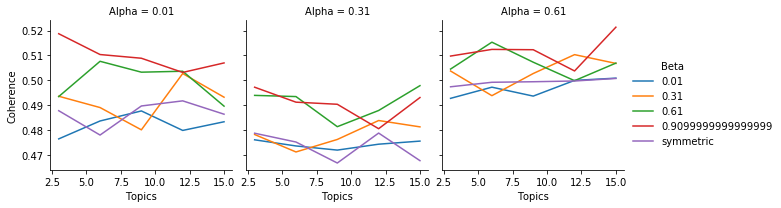

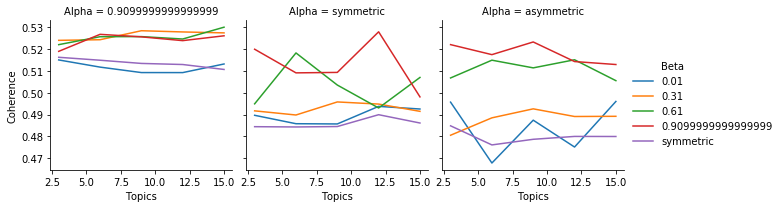

In [38]:
sns.relplot(x="Topics", y="Coherence", hue="Beta",
            col="Alpha", height=3, aspect = 1,
            kind="line", estimator=None, data=lda_tuning_results[lda_tuning_results.Alpha.isin(['0.01', '0.31', '0.61'])])

sns.relplot(x="Topics", y="Coherence", hue="Beta",
            col="Alpha", height=3, aspect = 1,
            kind="line", estimator=None, data=lda_tuning_results[~lda_tuning_results.Alpha.isin(['0.01', '0.31', '0.61'])])

In [43]:
pd.DataFrame(lda_model.print_topics()).to_csv('topic_words')

In [267]:
generic_topics

,topic_id,importance,Topic,word_count
0,0,0.411816,Value,80211
1,2,0.414410,Service,86144
2,3,0.217617,Wait,86705
3,6,0.531371,Delivery,116455
4,8,0.373923,Taste,69620


<BarContainer object of 5 artists>

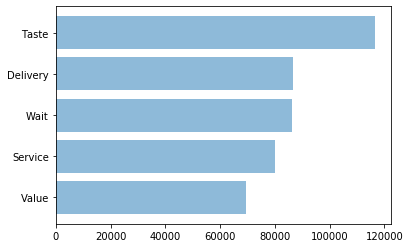

In [277]:
generic_topics = df[df.topic_id.isin([0, 2, 3, 6, 8])].groupby('topic_id').sum().reset_index()
generic_topics.sort_values(by='word_count', inplace=True)
generic_topics.insert(2, "Topic", ['Value', 'Service', 'Wait', 'Delivery', 'Taste'], True) 
plt.barh(generic_topics.Topic, generic_topics.word_count, alpha=0.5, label='Word Count')

In [258]:
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

In [256]:
topics = lda_model.show_topics(formatted=False)
topics

[(9,
  [('try', 0.16349544),
   ('also', 0.097348146),
   ('must', 0.07484841),
   ('amazing', 0.060057383),
   ('variety', 0.025846139),
   ('menu', 0.019086398),
   ('different', 0.018747669),
   ('sweet', 0.017771097),
   ('many', 0.017113276),
   ('flavour', 0.015385163)]),
 (2,
  [('service', 0.11548642),
   ('great', 0.0841258),
   ('staff', 0.0651956),
   ('visit', 0.03010158),
   ('friendly', 0.02981022),
   ('quick', 0.02217767),
   ('decent', 0.021466048),
   ('excellent', 0.016349673),
   ('courteous', 0.014897671),
   ('fast', 0.014799562)]),
 (1,
  [('love', 0.0925416),
   ('pizza', 0.041075014),
   ('cake', 0.0337798),
   ('delicious', 0.025103228),
   ('chocolate', 0.024806581),
   ('fresh', 0.021557786),
   ('dessert', 0.021082375),
   ('make', 0.019361846),
   ('perfect', 0.018259896),
   ('cheese', 0.01821492)]),
 (4,
  [('chicken', 0.11815292),
   ('really', 0.11621108),
   ('bangalore', 0.035949677),
   ('awesome', 0.028822232),
   ('special', 0.021610716),
   ('fry

In [263]:
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

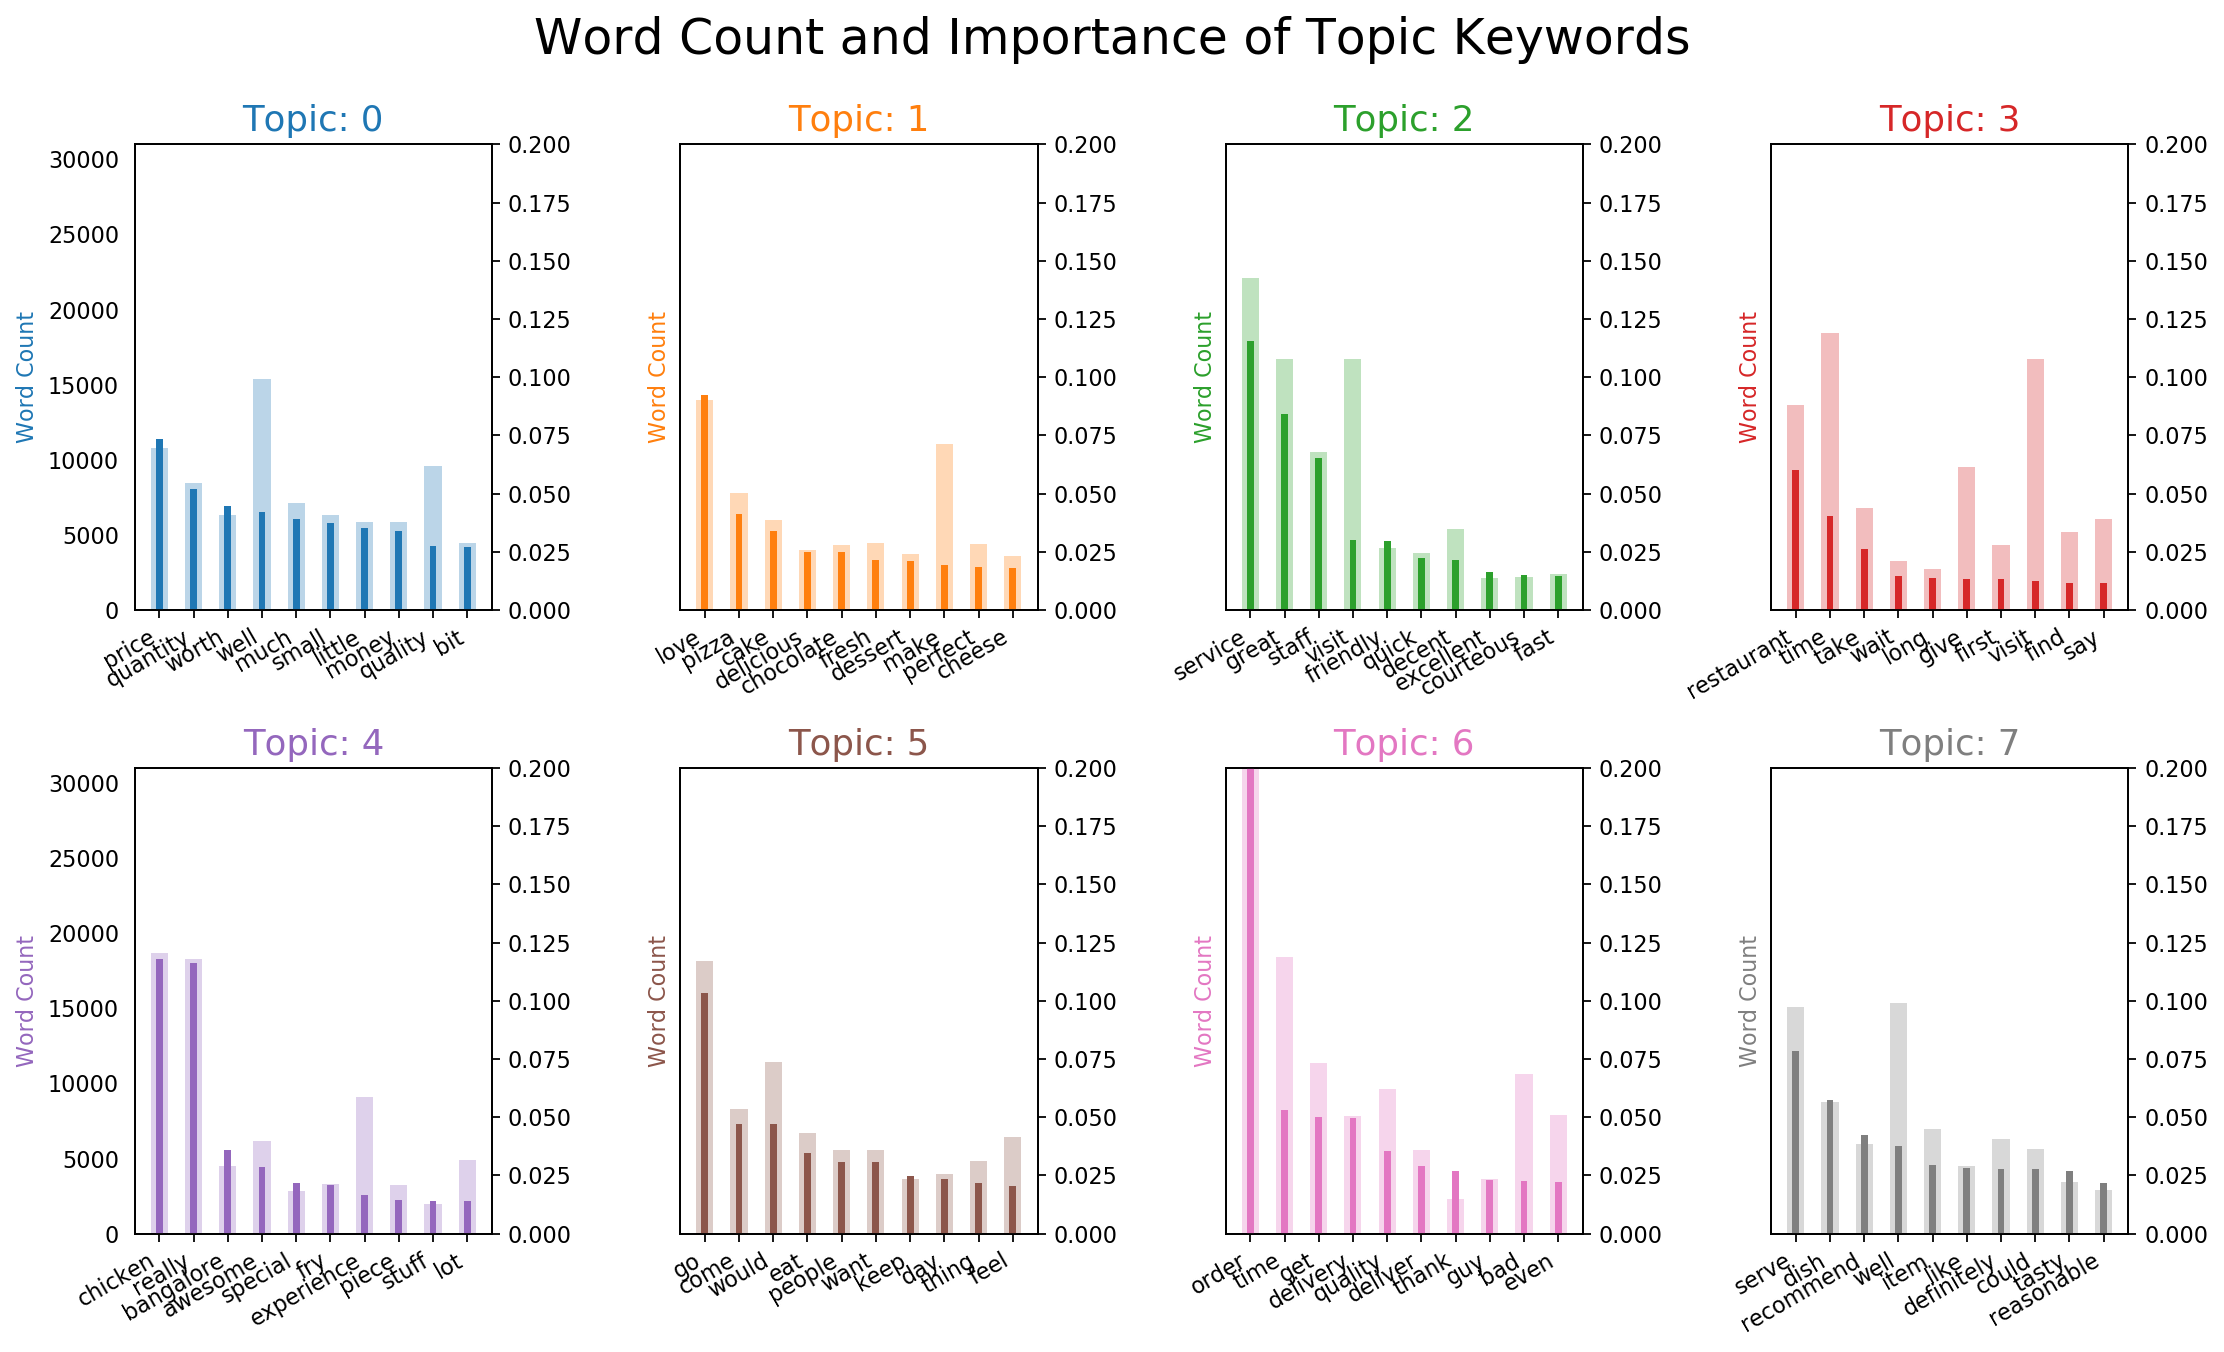

In [234]:
from collections import Counter
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2,4, figsize=(14,8), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.20); ax.set_ylim(0, 31000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
#     ax.legend(loc='upper left'); 
#     ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=1)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05) 
plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [32]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [73]:
pd.DataFrame(lda_model.show_topics(num_topics=11, num_words=200)).to_csv('topic_words')

In [54]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model")
lda_model.save(temp_file)

# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

In [ ]:
lsda

In [172]:
#Get the distribution of each topic by review

topic_distribution = []
for i in range(len(rating_df)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(11)]
    topic_vec.extend([rating_df.iloc[i].rest_key])
    topic_vec.extend([1])
    topic_distribution.append(topic_vec)

In [72]:
topic_dist_df = pd.DataFrame(data = topic_distribution, columns = ['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 
                                                          'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'restaurant_index', 'count'] )

topic_dist_df[topic_dist_df.restaurant_index == 0]

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,restaurant_index,count
75865,0.066810,0.066791,0.066758,0.066797,0.199869,0.066775,0.066802,0.066763,0.066753,0.132927,0.132954,0,1
85925,0.072385,0.071674,0.071473,0.071486,0.214204,0.071473,0.071453,0.074262,0.138561,0.071489,0.071542,0,1
85930,0.076970,0.076965,0.076959,0.076975,0.153706,0.076960,0.076978,0.153598,0.076951,0.076970,0.076968,0,1
93336,0.083353,0.083351,0.083347,0.083354,0.166486,0.083352,0.083353,0.083349,0.083346,0.083354,0.083354,0,1


In [78]:
city_data = data[['rest_key', 'location', 'listed_in(city)']]
topic_w_city = pd.merge(topic_dist_df, city_data, how='left', left_on = 'restaurant_index', right_on = 'rest_key' )

In [114]:
rest_topic_dist = topic_w_city.groupby('location').sum()
rest_topic_dist['Topic1'] = rest_topic_dist['Topic1']/rest_topic_dist['count']
# rest_topic_dist['Topic2'] = rest_topic_dist['Topic2']/rest_topic_dist['count']
rest_topic_dist['Topic3'] = rest_topic_dist['Topic3']/rest_topic_dist['count']
rest_topic_dist['Topic4'] = rest_topic_dist['Topic4']/rest_topic_dist['count']
rest_topic_dist['Topic5'] = rest_topic_dist['Topic5']/rest_topic_dist['count']
rest_topic_dist['Topic6'] = rest_topic_dist['Topic6']/rest_topic_dist['count']
rest_topic_dist['Topic7'] = rest_topic_dist['Topic7']/rest_topic_dist['count']
rest_topic_dist['Topic8'] = rest_topic_dist['Topic8']/rest_topic_dist['count']
rest_topic_dist['Topic9'] = rest_topic_dist['Topic9']/rest_topic_dist['count']
# rest_topic_dist['Topic10'] = rest_topic_dist['Topic10']/rest_topic_dist['count']
rest_topic_dist['Topic11'] = rest_topic_dist['Topic11']/rest_topic_dist['count']

rest_topic_dist

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,restaurant_index,count,rest_key
location,,,,,,,,,,,,,,
BTM,0.085472,453.478266,0.089340,0.088379,0.101163,0.091058,0.093831,0.087005,0.085864,465.137247,0.093428,121049972,4980,121049972
Banashankari,0.084502,226.171802,0.095747,0.088768,0.092896,0.094768,0.091920,0.089424,0.084334,213.000219,0.090521,56765095,2347,56765095
Banaswadi,0.086359,145.992272,0.089155,0.088883,0.102588,0.086487,0.093649,0.086605,0.083405,143.370913,0.091871,44034507,1515,44034507
Bannerghatta Road,0.084503,370.876515,0.089515,0.088378,0.102380,0.087868,0.097264,0.085978,0.086802,398.440304,0.091845,104967252,4148,104967252
Basavanagudi,0.084581,147.135616,0.094867,0.092190,0.085408,0.086461,0.092944,0.097062,0.085380,124.353336,0.089513,37612482,1417,37612482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bangalore,0.141393,3.080645,0.067842,0.093137,0.086089,0.089493,0.106038,0.077432,0.068964,3.301582,0.076211,595505,33,595505
Whitefield,0.085692,695.954070,0.091988,0.087704,0.097694,0.089583,0.092453,0.089393,0.094117,711.591900,0.091613,203653439,7830,203653439
Wilson Garden,0.080152,39.153079,0.085978,0.090203,0.097642,0.092255,0.093961,0.078221,0.084715,33.138547,0.096619,4956501,361,4956501


In [115]:
del rest_topic_dist['restaurant_index']
del rest_topic_dist['rest_key']
del rest_topic_dist['Topic2']
del rest_topic_dist['Topic10']
del rest_topic_dist['count']

In [118]:
rest_topic_dist = rest_topic_dist.reset_index()

In [119]:
topics_pivoted = rest_topic_dist.melt(id_vars=['location'], var_name='topic_number', value_name='topic_score')
topics_pivoted

,location,topic_number,topic_score
0,BTM,Topic1,0.085472
1,Banashankari,Topic1,0.084502
2,Banaswadi,Topic1,0.086359
3,Bannerghatta Road,Topic1,0.084503
4,Basavanagudi,Topic1,0.084581
...,...,...,...
805,West Bangalore,Topic11,0.076211
806,Whitefield,Topic11,0.091613
807,Wilson Garden,Topic11,0.096619
808,Yelahanka,Topic11,0.127624


In [120]:
topics_pivoted.to_csv('location_topic_distribution.csv', index=True)

In [39]:
rest_topic_dist = topic_dist_df.groupby('restaurant_index',).sum()
rest_topic_dist['Topic1'] = rest_topic_dist['Topic1']/rest_topic_dist['count']
rest_topic_dist['Topic2'] = rest_topic_dist['Topic2']/rest_topic_dist['count']
rest_topic_dist['Topic3'] = rest_topic_dist['Topic3']/rest_topic_dist['count']
rest_topic_dist['Topic4'] = rest_topic_dist['Topic4']/rest_topic_dist['count']
rest_topic_dist['Topic5'] = rest_topic_dist['Topic5']/rest_topic_dist['count']
rest_topic_dist['Topic6'] = rest_topic_dist['Topic6']/rest_topic_dist['count']
rest_topic_dist['Topic7'] = rest_topic_dist['Topic7']/rest_topic_dist['count']
rest_topic_dist['Topic8'] = rest_topic_dist['Topic8']/rest_topic_dist['count']
rest_topic_dist['Topic9'] = rest_topic_dist['Topic9']/rest_topic_dist['count']
rest_topic_dist['Topic10'] = rest_topic_dist['Topic10']/rest_topic_dist['count']
rest_topic_dist['Topic11'] = rest_topic_dist['Topic11']/rest_topic_dist['count']

rest_topic_dist

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,count
restaurant_index,,,,,,,,,,,,
0,0.074879,0.074695,0.074634,0.074653,0.183566,0.074640,0.074646,0.094490,0.091406,0.091185,0.364819,4
2,0.119557,0.085133,0.152809,0.111964,0.062538,0.077512,0.097508,0.085306,0.081913,0.062415,0.316722,5
11,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,1
14,0.080334,0.080294,0.159205,0.080299,0.080286,0.080317,0.099701,0.080242,0.098696,0.080319,0.160615,2
18,0.063202,0.093525,0.090553,0.062737,0.090266,0.062419,0.063186,0.252863,0.093281,0.063963,0.128012,2
...,...,...,...,...,...,...,...,...,...,...,...,...
51699,0.130077,0.085016,0.052808,0.111790,0.112305,0.063518,0.076443,0.097446,0.061831,0.116178,0.740711,8
51700,0.143082,0.091194,0.067271,0.090782,0.100991,0.078398,0.075583,0.080805,0.067792,0.116859,4.362236,50
51704,0.089677,0.093617,0.072588,0.075324,0.103955,0.082442,0.073498,0.094296,0.068684,0.142851,2.061378,20


In [44]:
rest_topic_dist.to_csv('restaurant_topic_distribution.csv', index=True)

In [63]:
from gensim.test.utils import datapath

# Save model to disk.
# temp_file = datapath("topic_model_11")
lda_model.save('topic_model')

# Load a potentially pretrained model from disk.
#lda = LdaModel.load(temp_file)

In [69]:
 = gensim.models.LdaModel.load('topic_model')

In [1]:
this_model.show_topics()

NameError: name 'this_model' is not defined

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = vectorizer.fit_transform(df_clean['question_lemmatize_clean'])

lda_model = LatentDirichletAllocation(n_components=20, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')

NameError: name 'df_clean' is not defined